In [1]:
import numpy as np
from w2v_utils import *

In [2]:
words, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

## Cosine Similarity

In [3]:
def cosine_similarity(u, v):
    if np.all(u == v):
        return 1 

    dot = np.dot(u, v)

    norm_u = np.sqrt(np.sum(u*u))

    norm_v = np.sqrt(np.sum(v*v))

    cosine_similarity = dot / (norm_u * norm_v)

    return cosine_similarity

In [4]:
#test function
father = word_to_vec_map["father"]
mother = word_to_vec_map["mother"]
ball = word_to_vec_map["ball"]
crocodile = word_to_vec_map["crocodile"]
france = word_to_vec_map["france"]
italy = word_to_vec_map["italy"]
paris = word_to_vec_map["paris"]
rome = word_to_vec_map["rome"]

print("cosine_similarity(father, mother) = ", cosine_similarity(father, mother))
print("cosine_similarity(ball, crocodile) = ",cosine_similarity(ball, crocodile))
print("cosine_similarity(france - paris, rome - italy) = ",cosine_similarity(france - paris, rome - italy))

cosine_similarity(father, mother) =  0.8909038442893615
cosine_similarity(ball, crocodile) =  0.27439246261379424
cosine_similarity(france - paris, rome - italy) =  -0.6751479308174202


## Word Analogy Task

In [7]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()

    #Get the word embeddings
    e_a, e_b, e_c = word_to_vec_map[word_a], word_to_vec_map[word_b], word_to_vec_map[word_c]

    words = word_to_vec_map.keys()
    max_cosine_sim = -100
    best_word = None 

    for w in words:
        if w == word_c:
            continue

        
        cosine_sim = cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)

        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim 
            best_word = w 
    
    return best_word

In [8]:
#test function
triads_to_try = [('italy', 'italian', 'spain'), ('india', 'delhi', 'japan'), ('man', 'woman', 'boy'), ('small', 'smaller', 'large')]
for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad, word_to_vec_map)))

italy -> italian :: spain -> spanish
india -> delhi :: japan -> tokyo
man -> woman :: boy -> girl
small -> smaller :: large -> smaller


## Debiasing Word Vectors

In [9]:
g = word_to_vec_map['woman'] - word_to_vec_map['man']
print(g)

[-0.087144    0.2182     -0.40986    -0.03922    -0.1032      0.94165
 -0.06042     0.32988     0.46144    -0.35962     0.31102    -0.86824
  0.96006     0.01073     0.24337     0.08193    -1.02722    -0.21122
  0.695044   -0.00222     0.29106     0.5053     -0.099454    0.40445
  0.30181     0.1355     -0.0606     -0.07131    -0.19245    -0.06115
 -0.3204      0.07165    -0.13337    -0.25068714 -0.14293    -0.224957
 -0.149       0.048882    0.12191    -0.27362    -0.165476   -0.20426
  0.54376    -0.271425   -0.10245    -0.32108     0.2516     -0.33455
 -0.04371     0.01258   ]


In [10]:
print ('List of names and their similarities with constructed vector:')

# girls and boys name
name_list = ['john', 'marie', 'sophie', 'ronaldo', 'priya', 'rahul', 'danielle', 'reza', 'katy', 'yasmin']

for w in name_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

List of names and their similarities with constructed vector:
john -0.23163356145973724
marie 0.315597935396073
sophie 0.31868789859418784
ronaldo -0.3124479685032943
priya 0.17632041839009402
rahul -0.16915471039231722
danielle 0.24393299216283892
reza -0.07930429672199552
katy 0.2831068659572615
yasmin 0.23313857767928758


In [11]:
print('Other words and their similarities:')
word_list = ['lipstick', 'guns', 'science', 'arts', 'literature', 'warrior','doctor', 'tree', 'receptionist', 
             'technology',  'fashion', 'teacher', 'engineer', 'pilot', 'computer', 'singer']
for w in word_list:
    print (w, cosine_similarity(word_to_vec_map[w], g))

Other words and their similarities:
lipstick 0.2769191625638266
guns -0.1888485567898898
science -0.060829065409296994
arts 0.008189312385880328
literature 0.06472504433459927
warrior -0.20920164641125288
doctor 0.11895289410935041
tree -0.07089399175478091
receptionist 0.33077941750593737
technology -0.13193732447554296
fashion 0.03563894625772699
teacher 0.17920923431825664
engineer -0.08039280494524072
pilot 0.0010764498991916787
computer -0.10330358873850498
singer 0.1850051813649629


### Neutralize Bias for Non-Gender Specific Words

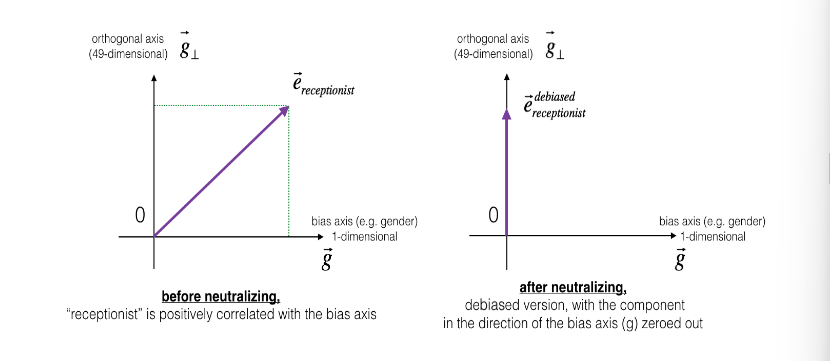

In [12]:
# The paper assumes all word vectors to have L2 norm as 1 and hence the need for this calculation
from tqdm import tqdm
word_to_vec_map_unit_vectors = {
    word: embedding / np.linalg.norm(embedding)
    for word, embedding in tqdm(word_to_vec_map.items())
}
g_unit = word_to_vec_map_unit_vectors['woman'] - word_to_vec_map_unit_vectors['man']

100%|██████████| 400000/400000 [00:01<00:00, 298763.11it/s]


In [27]:
def neutralize(word, g, word_to_vec_map):
    e = word_to_vec_map[word]

    e_bias_component = (np.dot(e ,g) / np.sum(g * g)) * g

    e_debiased = e - e_bias_component

    return e_debiased

In [28]:
word = "receptionist"
print("cosine similarity between " + word + " and g, before neutralizing: ", cosine_similarity(word_to_vec_map[word], g))

e_debiased = neutralize(word, g_unit, word_to_vec_map_unit_vectors)
print("cosine similarity between " + word + " and g_unit, after neutralizing: ", cosine_similarity(e_debiased, g_unit))

cosine similarity between receptionist and g, before neutralizing:  0.33077941750593737
cosine similarity between receptionist and g_unit, after neutralizing:  -6.444013900514123e-17


### Equalization Algorithm for Gender-Specific Words

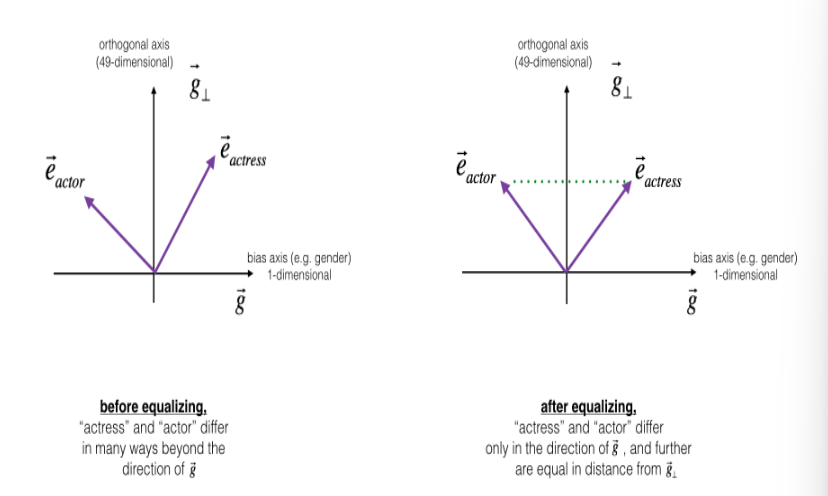

In [29]:
def equalize(pair, bias_axis, word_to_vec_map):
    w1, w2 = pair
    e_w1, e_w2 = word_to_vec_map[w1],word_to_vec_map[w2]
    

    mu = (e_w1 + e_w2) / 2


    mu_B = np.dot(mu, bias_axis) / np.sum(bias_axis * bias_axis) * bias_axis
    mu_orth = mu - mu_B

 
    e_w1B = np.dot(e_w1, bias_axis) / np.sum(bias_axis * bias_axis) * bias_axis
    e_w2B = np.dot(e_w2, bias_axis) / np.sum(bias_axis * bias_axis) * bias_axis
        
 
    corrected_e_w1B = np.sqrt(np.abs(1 - np.sum(mu_orth * mu_orth))) * (e_w1B - mu_B) / np.linalg.norm(e_w1 - mu_orth - mu_B)
    corrected_e_w2B = np.sqrt(np.abs(1 - np.sum(mu_orth * mu_orth))) * (e_w2B - mu_B) / np.linalg.norm(e_w2 - mu_orth - mu_B)

 
    e1 = corrected_e_w1B + mu_orth
    e2 = corrected_e_w2B + mu_orth
                                                                

    
    return e1, e2

In [30]:
print("cosine similarities before equalizing:")
print("cosine_similarity(word_to_vec_map[\"man\"], gender) = ", cosine_similarity(word_to_vec_map["man"], g))
print("cosine_similarity(word_to_vec_map[\"woman\"], gender) = ", cosine_similarity(word_to_vec_map["woman"], g))
print()
e1, e2 = equalize(("man", "woman"), g_unit, word_to_vec_map_unit_vectors)
print("cosine similarities after equalizing:")
print("cosine_similarity(e1, gender) = ", cosine_similarity(e1, g_unit))
print("cosine_similarity(e2, gender) = ", cosine_similarity(e2, g_unit))

cosine similarities before equalizing:
cosine_similarity(word_to_vec_map["man"], gender) =  -0.1171109576533683
cosine_similarity(word_to_vec_map["woman"], gender) =  0.3566661884627037

cosine similarities after equalizing:
cosine_similarity(e1, gender) =  -0.23871136142883706
cosine_similarity(e2, gender) =  0.23871136142883695


# References
The debiasing algorithm is from Bolukbasi et al., 2016, [Man is to Computer Programmer as Woman is to
Homemaker? Debiasing Word Embeddings](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf)